## 【量化分析】KD指標回測實戰
本文來源[Tej medium](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E9%87%8F%E5%8C%96%E5%88%86%E6%9E%90-%E5%8D%81-kd%E6%8C%87%E6%A8%99%E5%9B%9E%E6%B8%AC%E5%AF%A6%E6%88%B0-5e743c10468b)

### 一、前言

KD指標是技術分析常見的指標之一，主要用於判斷股價當前的強弱程度與可能反轉的時機。KD指標的數值介於0-100，一般以50作為分水嶺，當指標大於50時，表示股價處於強勢階段；反之，當股價小於50時，股價屬於弱勢階段。另外，當KD指標小於20時，股票往往有超賣的跡象，隨時有反轉向上的可能；反之當KD指標大於80時，股票往往有超買的跡象，隨時有反轉向下的可能。因此，許多人依此來建構交易訊號，作為買賣股票的依據。

KD指標的計算流程:

- RSV = ((當日收盤價-近N日的最低價)/(近N日的最高價-近N日的最低價))*100
- K值 = 昨日K值 × (2/3) + 當日RSV × (1/3)
- D值 = 昨日D值 × (2/3) + 當日K值 × (1/3)

從算式來看，可以把RSV解讀成當日股價相較於近N日 (本文N = 9)股價，是屬於較強勢還是弱勢。K值，又被稱為快線，因為受到當日股價強弱的影響較大；而D值計算的原理如同再進行一次平滑，故對當前股價變化反應較慢。

本文採用KD指標來判斷股價反轉時機，利用以下進出場規則建立交易策略並進行回測:
- K ≤ 20，買入，因其代表股價處於較弱、市場過冷
- K ≥ 80，賣出，代表市場過熱，因此選擇獲利了結

### 二、 環境設定 & import package
2.1 輸入tejapi key

In [1]:
import os

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'your key'

2.2 import package

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import zipline
from zipline.data import bundles
from zipline.sources.TEJ_Api_Data import get_universe

from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline   

from zipline.api import *
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                            get_Benchmark_Return)

import pyfolio as pf

plt.rcParams['axes.unicode_minus'] = False

C:\Users\StevenChen\AppData\Roaming\Python\Python310\site-packages\zipline\pipeline\data\tejquant.py:3: FutureWarning: `zipline.pipeline.data.tejquant` will be deprecated in a future version, which includes the removal of the `TQDataSet` class. Please migrate to `zipline.pipeline.data.TQFundamentals` for accessing the equivalent classes: `TQData`, `TQDataSet`, `TQAltData`, and `TQAltDataSet`. 
  warnings.warn(


### 三、樣本&期間
3.1 設定股票池與期間

- 股票池：抓取台灣50指數的股票(總計81筆)與加權股價報酬指數(IR0001)
- 期間：從2012-2022年
- 綁入名稱為tquant的資料庫
- 指定交易日為台股交易日誌:TEJ_XTAI

利用tejapi將開高低收量、調整股價資料綁入zipline

In [3]:
# set backtest period
start = '2012-01-01'
end = '2022-12-30'

# 抓取台灣50指數的股票
StockList = get_universe(start, end, idx_id='IX0002')
StockList.append('IR0001')

os.environ['ticker'] = ' '.join(StockList)
os.environ['mdate'] = start+' '+end

# calendar------------------------------------------
calendar_name = 'TEJ_XTAI'  
# bundle_name---------------------------------------
bundle_name = 'tquant'

!zipline ingest -b tquant

Currently used TEJ API key call quota 213/100000 (0.21%)
Currently used TEJ API key data quota 40698191/10000000 (406.98%)
Merging daily equity files:
Currently used TEJ API key call quota 219/100000 (0.22%)
Currently used TEJ API key data quota 41112632/10000000 (411.13%)


C:\Users\StevenChen\AppData\Roaming\Python\Python310\site-packages\zipline\pipeline\data\tejquant.py:3: FutureWarning: `zipline.pipeline.data.tejquant` will be deprecated in a future version, which includes the removal of the `TQDataSet` class. Please migrate to `zipline.pipeline.data.TQFundamentals` for accessing the equivalent classes: `TQData`, `TQDataSet`, `TQAltData`, and `TQAltDataSet`. 
  warnings.warn(
[2024-02-20 08:04:03.898567] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-20 08:04:35.972564] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### 四、建構交易策略

#### 4.1 交易策略參數設定

**交易成本設定：**
- 初始資金為1,000,000元
- 設定單次買賣股票金額的0.29%為佣金費用
- 設定0%為滑價成本

In [4]:
"""
Model Settings
"""
starting_portfolio = 1e6
'''
cost params setting
'''
commission_pct = 0.0029
slippage_volume_limit = 1.0
slippage_impact = 0

#### 4.2 建立Pipeline函式

取得 TQuant Lab 的內建因子 *FastStochasticOscillator* ，即為交易策略所需的 K 值

##### Parameters:
* inputs: _zipline.pipeline.data.Dataset.BoundColumn_
        計算所需價量資料，預設 = EquityPricing.close, EquityPricing.low, EquityPricing.high。
* window_lengthL: _int_
        以 n 天為週期，預設 = 14。

In [5]:
from zipline.pipeline.factors import FastStochasticOscillator

def make_pipeline():
    
    return Pipeline(
        columns = {
            "FastStochasticOscillator": FastStochasticOscillator(
                inputs = [TWEquityPricing.close, TWEquityPricing.low, TWEquityPricing.high],
                window_length = 10
            )
        }
    )

start_date = pd.Timestamp('2022-01-01',tz='utc')
end_date = pd.Timestamp('2022-12-26',tz='utc')
result = run_pipeline(make_pipeline(), start_date, end_date)

result

FastStochasticOscillator
2022-01-03 00:00:00+00:00 Equity(0 [1101])                    81.481481
                          Equity(1 [1102])                    93.548387
                          Equity(2 [1216])                    52.380952
                          Equity(3 [1301])                    55.555556
                          Equity(4 [1303])                    75.000000
...                                                                 ...
2022-12-26 00:00:00+00:00 Equity(77 [8046])                   17.757009
                          Equity(78 [8454])                   65.853659
                          Equity(79 [9904])                   90.000000
                          Equity(80 [9910])                   63.095238
                          Equity(81 [IR0001])                       NaN

[18634 rows x 1 columns]

#### 4.3 建立 initialize 函式

`inintialize` 函式用於定義交易開始前的每日交易環境，與此例中我們設置:

* 交易手續費
* 流動性滑價
* 買入持有加權股價報酬指數(IR0001)的報酬作為基準
* 將 Pipeline 導入交易流程中

In [6]:
bundle = bundles.load('tquant')

def initialize(context):
    set_commission(PerDollar(cost=commission_pct))
    set_slippage(VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)) 
    # setting benchmark    
    set_benchmark(symbol('IR0001'))  
    attach_pipeline(make_pipeline(), 'mystrategy')

#### 4.4 建立 handle_date 函式

`handle_data` 函式用於處理每天的交易策略或行動。

本範例運用KD指標來建構交易策略，在指標顯示超賣時買進，在指標顯示超買時賣出。

**交易策略的進出場規則：**

- Long Entry:
    - K ≤ 20，買入股票池中條件成立股票，配置帳戶資金1%。

- Short Entry:
    - K ≥ 80，賣出條件成立股票。

In [7]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')  # 取得每天 pipeline 的 K 值
    for i in out_dir.index:
        short_kd = out_dir.loc[i, 'FastStochasticOscillator']
        position = context.portfolio.positions[i].amount
        if (position == 0 and short_kd <= 20) :
            order_target_percent(i, 0.01)
                
        elif (position > 0 and short_kd >= 80) :
            order_target_percent(i, 0.0)

#### 4.5 執行交易策略

使用 `run_algorithm` 執行上述所編撰的交易策略，設置交易期間為 2022-01-01 到 2022-12-26，所使用資料集為 *tquant*，初始資金為 1,000,000 元 (於4.1設定初始資金)。其中輸出的 __results__ 就是每日績效與交易的明細表。

In [8]:
from zipline import run_algorithm

start_date = pd.Timestamp('2022-01-01',tz='utc')
end_date = pd.Timestamp('2022-12-26',tz='utc')

results = run_algorithm(start= start_date,  
                        end=end_date,
                        initialize=initialize,                      
                        capital_base=starting_portfolio,                      
                        handle_data=handle_data,
                        data_frequency='daily',
                        bundle='tquant'
                        )
results

,period_open,period_close,ending_exposure,starting_value,ending_value,starting_cash,ending_cash,portfolio_value,longs_count,shorts_count,...,max_drawdown,max_leverage,trading_days,period_label,algo_volatility,algorithm_period_return,benchmark_period_return,excess_return,benchmark_volatility,treasury_period_return
2022-01-03 13:30:00+08:00,2022-01-03 09:01:00+08:00,2022-01-03 13:30:00+08:00,0.00,0.00,0.00,1000000.000000,1000000.000000,1000000.000000,0,0,...,0.000000,0.000000,1,2022-01,NaN,0.000000,0.002836,-0.002836,NaN,0.0
2022-01-04 13:30:00+08:00,2022-01-04 09:01:00+08:00,2022-01-04 13:30:00+08:00,10048.50,0.00,10048.50,1000000.000000,989922.359350,999970.859350,1,0,...,-0.000029,0.010049,2,2022-01,0.000327,-0.000029,0.016879,-0.016908,0.125348,0.0
2022-01-05 13:30:00+08:00,2022-01-05 09:01:00+08:00,2022-01-05 13:30:00+08:00,60288.15,10048.50,60288.15,989922.359350,939493.388215,999781.538215,6,0,...,-0.000218,0.060301,3,2022-01,0.001618,-0.000218,0.015430,-0.015649,0.126476,0.0
2022-01-06 13:30:00+08:00,2022-01-06 09:01:00+08:00,2022-01-06 13:30:00+08:00,109184.60,60288.15,109184.60,939493.388215,890059.544605,999244.144605,11,0,...,-0.000756,0.109267,4,2022-01,0.003918,-0.000756,0.008183,-0.008939,0.141975,0.0
2022-01-07 13:30:00+08:00,2022-01-07 09:01:00+08:00,2022-01-07 13:30:00+08:00,167418.50,109184.60,167418.50,890059.544605,831236.250325,998654.750325,17,0,...,-0.001345,0.167644,5,2022-01,0.004428,-0.001345,-0.002694,0.001349,0.153134,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20 13:30:00+08:00,2022-12-20 09:01:00+08:00,2022-12-20 13:30:00+08:00,400157.60,391376.70,400157.60,492729.944788,476513.719968,876671.319968,47,0,...,-0.129281,0.675589,238,2022-12,0.085309,-0.123329,-0.184921,0.061592,0.200801,0.0
2022-12-21 13:30:00+08:00,2022-12-21 09:01:00+08:00,2022-12-21 13:30:00+08:00,444341.95,400157.60,444341.95,476513.719968,432612.775368,876954.725368,52,0,...,-0.129281,0.675589,239,2022-12,0.085135,-0.123045,-0.181218,0.058173,0.200454,0.0
2022-12-22 13:30:00+08:00,2022-12-22 09:01:00+08:00,2022-12-22 13:30:00+08:00,486532.55,444341.95,486532.55,432612.775368,397888.165188,884420.715188,56,0,...,-0.129281,0.675589,240,2022-12,0.085461,-0.115579,-0.169220,0.053640,0.200656,0.0
2022-12-23 13:30:00+08:00,2022-12-23 09:01:00+08:00,2022-12-23 13:30:00+08:00,481903.75,486532.55,481903.75,397888.165188,398501.750453,880405.500453,56,0,...,-0.129281,0.675589,241,2022-12,0.085383,-0.119594,-0.179074,0.059479,0.200563,0.0


利用cumsum().plot()畫出累計報酬率的圖

<AxesSubplot:>

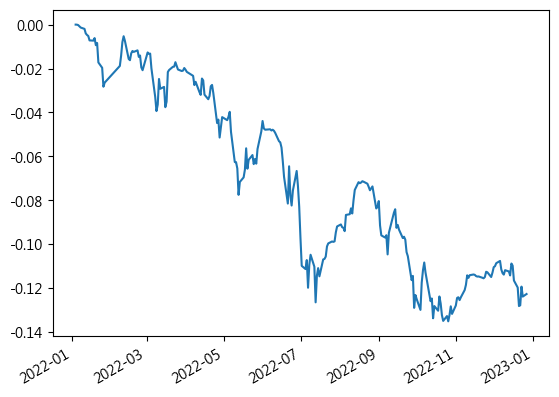

In [9]:
results.returns.cumsum().plot()

### 五、策略績效分析
5.1 利用pyfolio分析評估策略的風險與報酬表現

Start date,2022-01-03
End date,2022-12-26
Total months,11
,Backtest
Annual return,-12.315%
Cumulative returns,-11.856%
Annual volatility,8.522%
Sharpe ratio,-1.50
Calmar ratio,-0.95
Stability,0.87
Max drawdown,-12.928%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.93,2022-01-03,2022-10-25,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,-0.05%,-1.62%,1.70%


Top 10 long positions of all time,max
sid,
6415,1.21%
2615,1.14%
2603,1.12%
2609,1.12%
2498,1.11%
2201,1.11%
8454,1.10%
1802,1.10%
1722,1.09%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
6415,1.21%
2615,1.14%
2603,1.12%
2609,1.12%
2498,1.11%
2201,1.11%
8454,1.10%
1802,1.10%
1722,1.09%


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


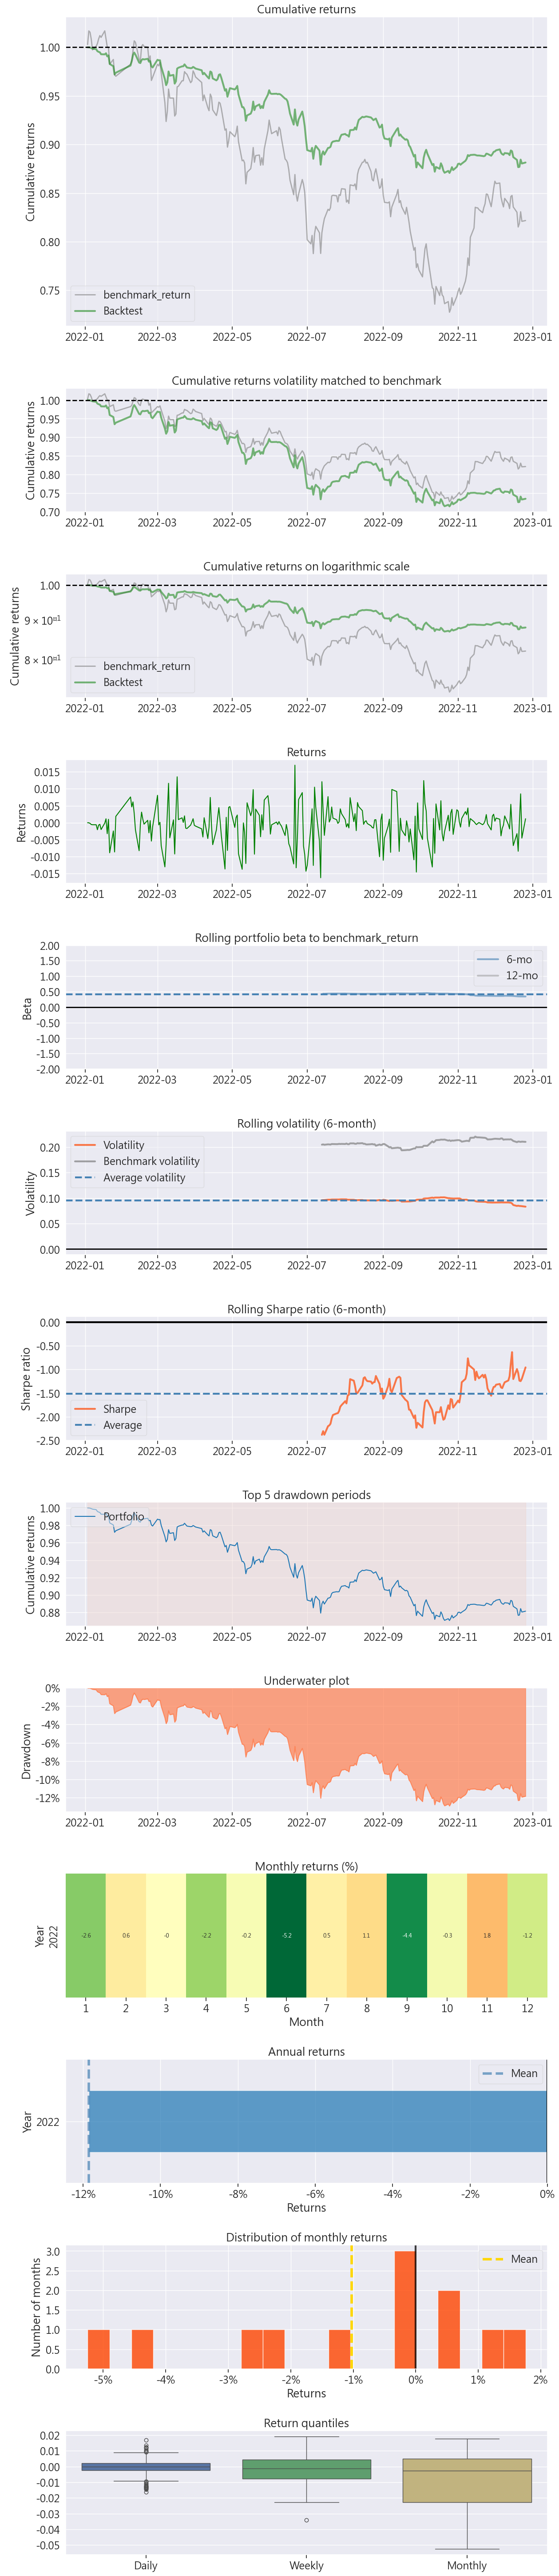

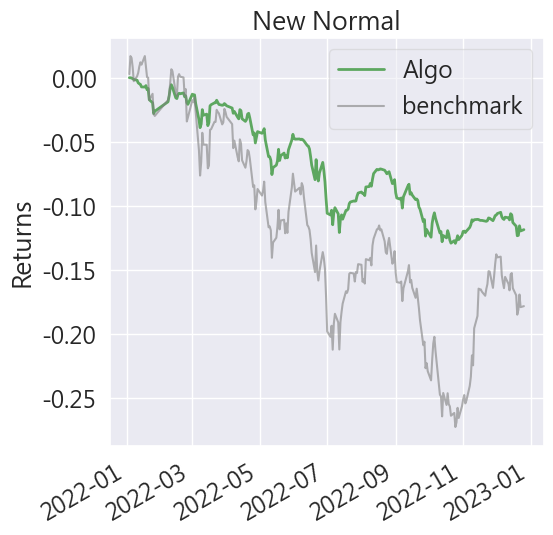

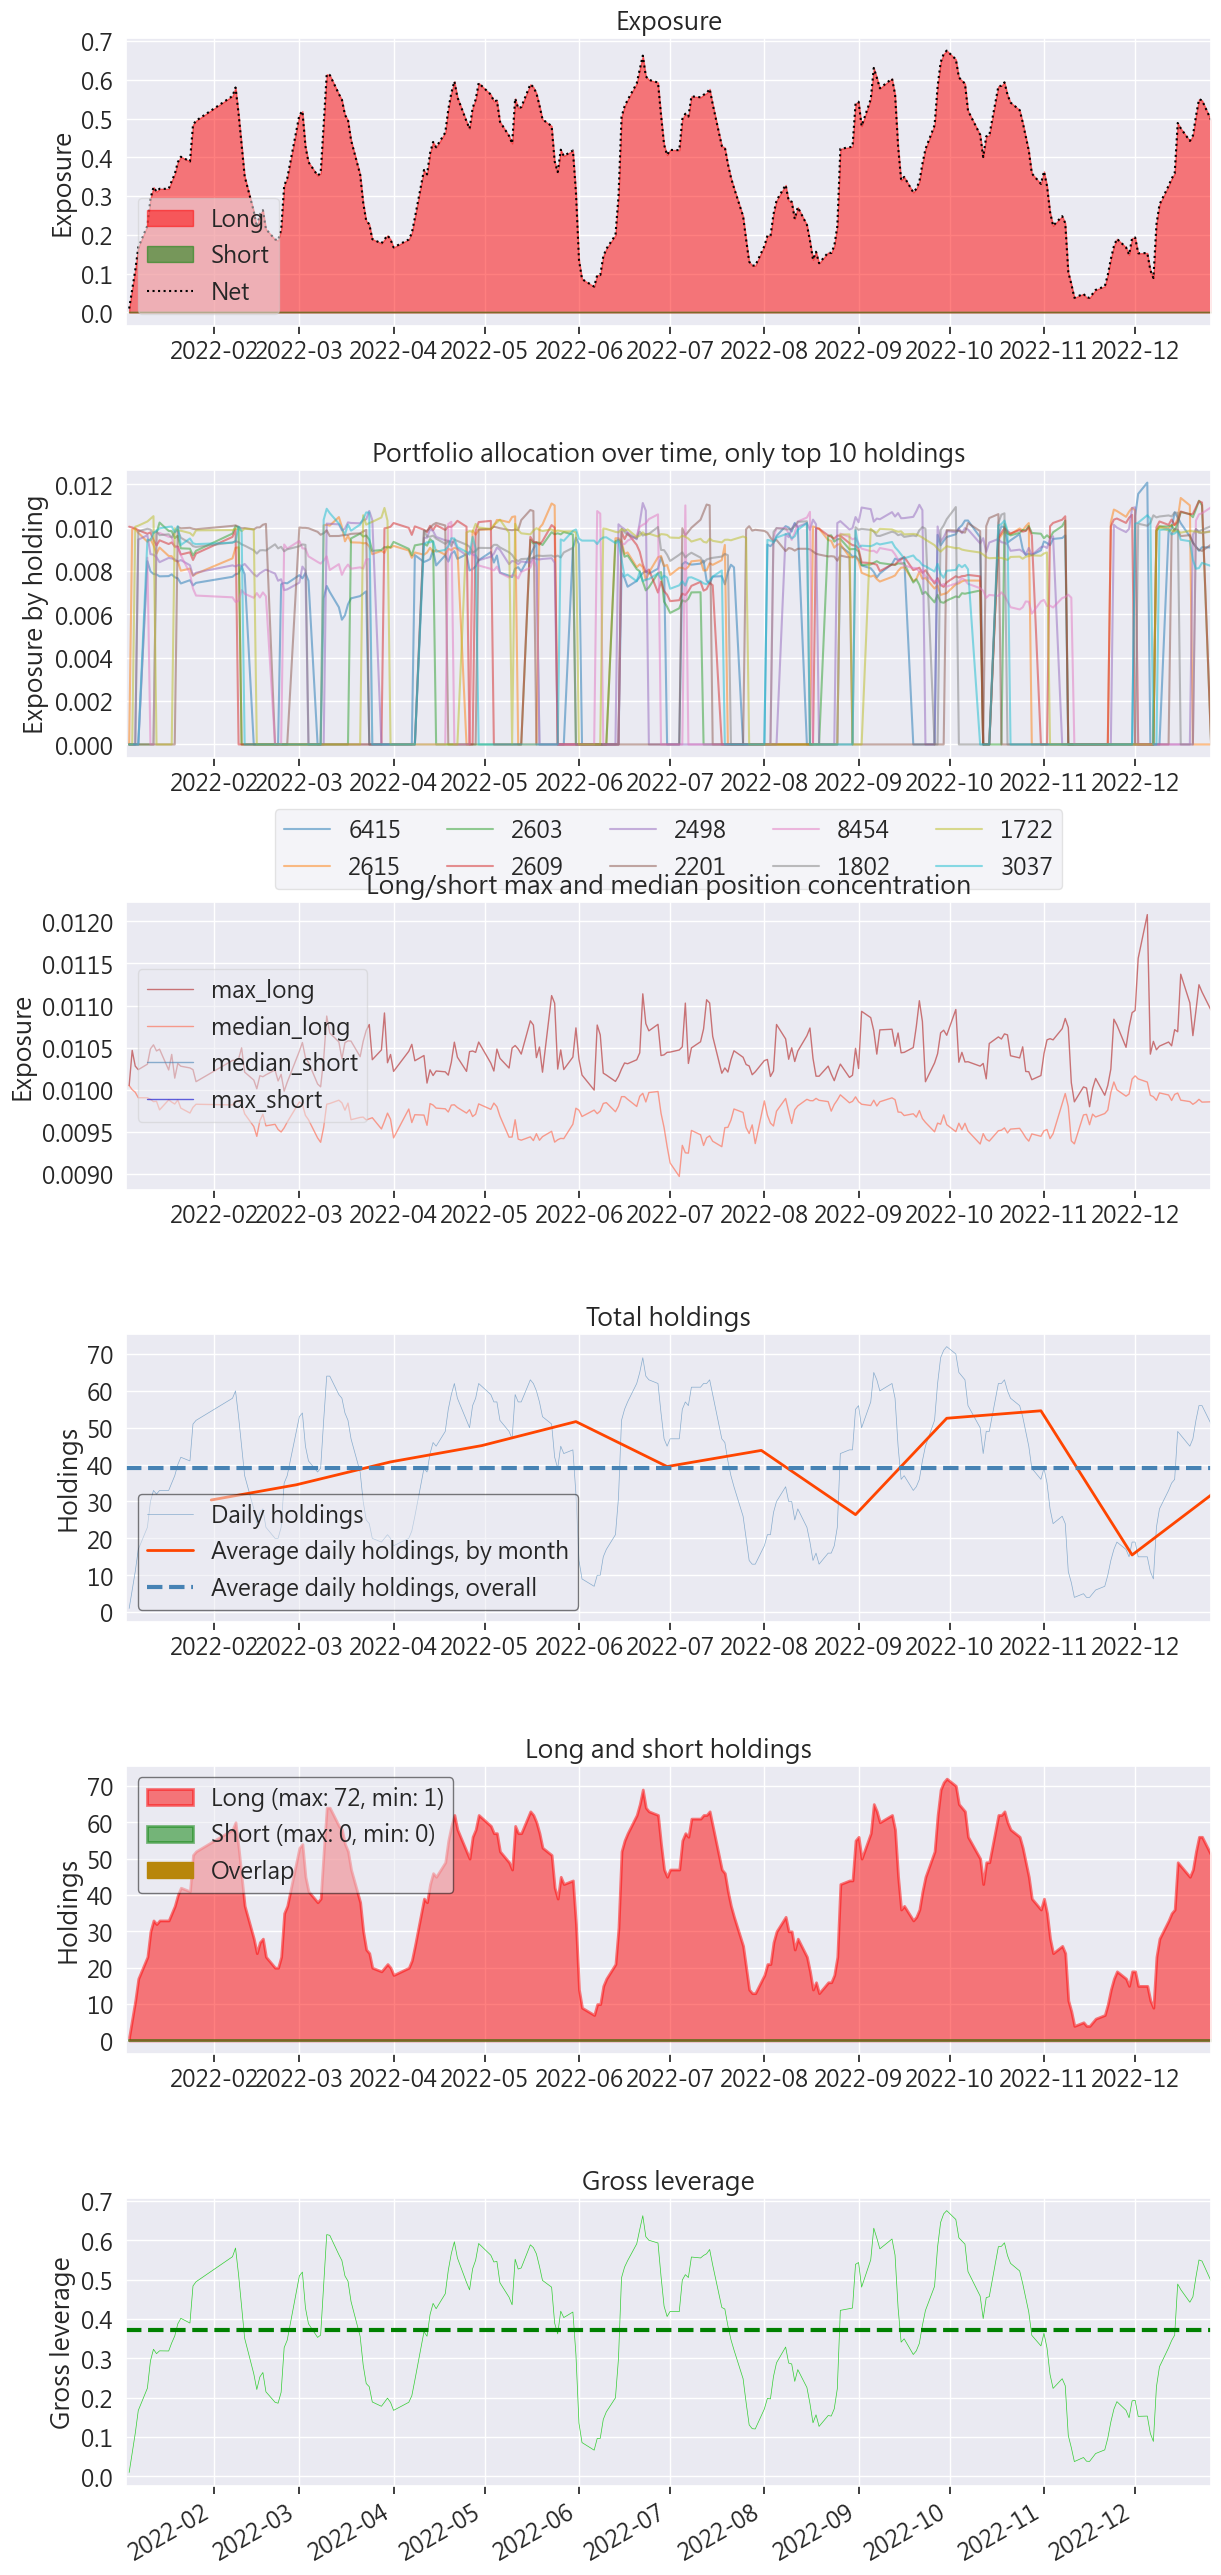

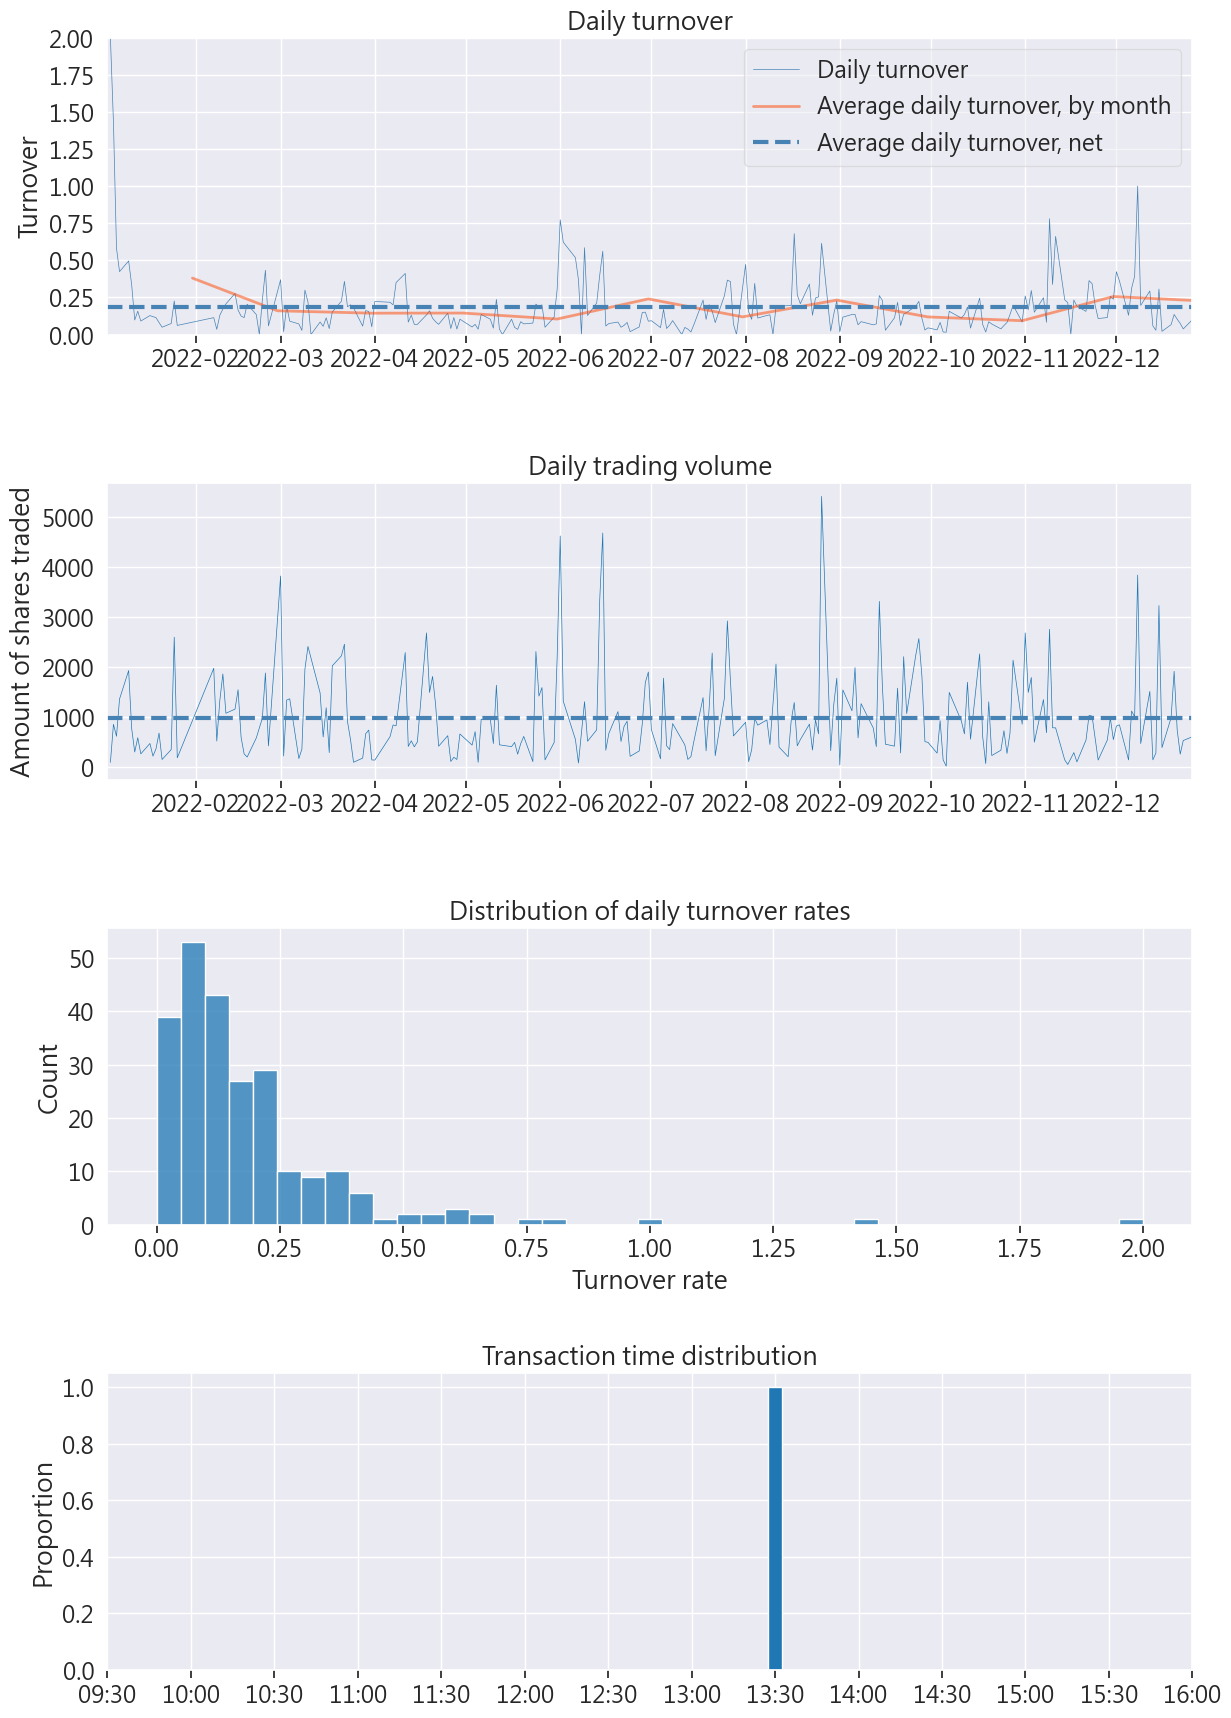

In [10]:
import pyfolio as pf
import empyrical

bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions=bt_positions, transactions=bt_transactions,
                        benchmark_rets=benchmark_rets,
                        #live_start_date='2022-01-01', 
                        round_trips=False)